# Labels / emotions for POLITISKY24

This notebook takes the POLITISKY24 stance dataset and adds an **emotion label** to each post using a pretrained classifier.
The EDA-style goal is to make it clear:

- what data we start from,
- how we turn `Context` into plain text,
- what the model produces (label + confidence),
- and what we can learn about **hashtags** once posts are grouped by emotion.

Source dataset reference:
https://zenodo.org/records/15616911

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from collections import Counter
import itertools
import numpy as np
import seaborn as sns


In [6]:
import random

random.seed(42)

## Load the stance dataset

We read the parquet file into `df` and print the number of rows.  
In this run, the dataset contains **16,044 rows**.


In [ ]:
from pathlib import Path

THIS_DIR = Path.cwd() 

ROOT_DIR = THIS_DIR.parents[1]

INPUT_DIR = ROOT_DIR / "datasets"
OUTPUT_DIR = ROOT_DIR / "annotated_datasets"

In [ ]:
df = pd.read_parquet(f"{INPUT_DIR}/llm_annotated_full_user_stance_dataset.parquet")
print(len(df))


16044


## Normalize `Context` into a plain text field

`Context` can appear as a list/array (or already as a string).  
To make the downstream model call consistent, we create:

- `df["text"]`: a single string per row (joining lists with spaces, otherwise casting to string).

This is purely preprocessing: we are not changing content, just standardizing the format.


In [8]:
df['text'] = df['Context'].apply(lambda x: ' '.join(x) if isinstance(x, (list, np.ndarray)) else str(x))


In [9]:
df['text'] = df['text'].astype(str)

## Emotion classifier

We use a Hugging Face `pipeline` for text classification with:

- model: `j-hartmann/emotion-english-distilroberta-base`

The pipeline returns, for each input text:
- a predicted emotion label, and
- an associated confidence score.


In [5]:
from transformers import pipeline
import torch

device = 0 if torch.cuda.is_available() else -1  # GPU if available
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    tokenizer="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=True,
    truncation=True,
    device=device
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


## Run inference in batches

We process texts in batches (to be memory-friendly) and collect:
- `pred_labels`: the predicted emotion per post, and
- `pred_scores`: the model confidence for that label.


In [10]:
from tqdm import tqdm

batch_size = 32
results = []

texts_list = df['text'].tolist()

for i in tqdm(range(0, len(texts_list), batch_size), desc="Processing batches"):
    batch = texts_list[i:i+batch_size]
    batch_results = emotion_classifier(batch, batch_size=batch_size)
    results.extend(batch_results)



Processing batches: 100%|██████████| 502/502 [02:54<00:00,  2.88it/s]


In [11]:
pred_labels = []
pred_scores = []

for res in results:
    best = max(res, key=lambda x: x['score'])
    pred_labels.append(best['label'])
    pred_scores.append(best['score'])


## Build a results table

After inference, we assemble `df_results` with:
- the cleaned `text`,
- the predicted `sentiment` (emotion label), and
- the model `confidence`.

Printing the table here is a quick integrity check that labels and scores line up row-by-row.


In [12]:
df_results = pd.DataFrame({
    'text': texts_list,
    'sentiment': pred_labels,
    'confidence': pred_scores
})

df_results.head()


,text,sentiment,confidence
0,Assuming Harris is the pick. Biden might have ...,fear,0.401503
1,Gonna fucking Battle Royale us into a Trump pr...,anger,0.851509
2,Kamala/Harris Kamala Harris is very good at th...,neutral,0.690806
3,"Not to get too political on here, but I really...",fear,0.288336
4,To any and ALL MAGA calling for unity and the ...,fear,0.616217


## Save predictions

We write the emotion-labeled table to `bluesky_emotions.csv` so it can be reused without rerunning the model.


In [ ]:
df_results.to_csv(f"{OUTPUT_DIR}/emotions/bluesky_emotions.csv", index=False)

## Hashtags and emotion: building a tag graph

From the emotion-labeled posts we extract hashtags (regex `#\w+`), then build a hashtag graph.

The key idea in the code below:
- each hashtag becomes a node,
- edges reflect co-occurrence / relationships defined by the constructed graph logic,
- and we attach an “emotion profile” to tags based on the sentiments of the posts they appear in.

We then cluster tags (KMeans) using these emotion profiles, and visualize the resulting network.


In [14]:
import re

df_results['hashtags'] = df_results['text'].apply(lambda x: re.findall(r"#\w+", x))


In [15]:


edge_counts = Counter()

for tags in df_results['hashtags']:
    tags = list(set(tags))
    for t1, t2 in itertools.combinations(tags, 2):
        edge_counts[(t1, t2)] += 1

G = nx.Graph()
for (t1, t2), w in edge_counts.items():
    if w >= 3:
        G.add_edge(t1, t2, weight=w)


### Hashtag network with clustered emotion profiles (figures)

The following figures are the network visualizations produced by the graph + clustering pipeline above.
Nodes are annotated with a cluster name derived from their average sentiment distribution.


We analyze sentiment-based hashtag clustering under different numbers of clusters (k ∈ {3,4,5,6,7}) using a fixed graph layout. Node colors indicate dominant sentiment, node sizes reflect hashtag frequency, and heatmaps summarize the average sentiment distribution per cluster. This allows us to assess both the stability and granularity of affective groupings

In [24]:

rows = []
for _, row in df_results.iterrows():
    for tag in row["hashtags"]:
        rows.append({
            "tag": tag,
            "sentiment": row["sentiment"]
        })

tag_df = pd.DataFrame(rows)
sent_dist = (
    tag_df
    .groupby(["tag", "sentiment"])
    .size()
    .unstack(fill_value=0)
)
sent_dist_norm = sent_dist.div(sent_dist.sum(axis=1), axis=0)


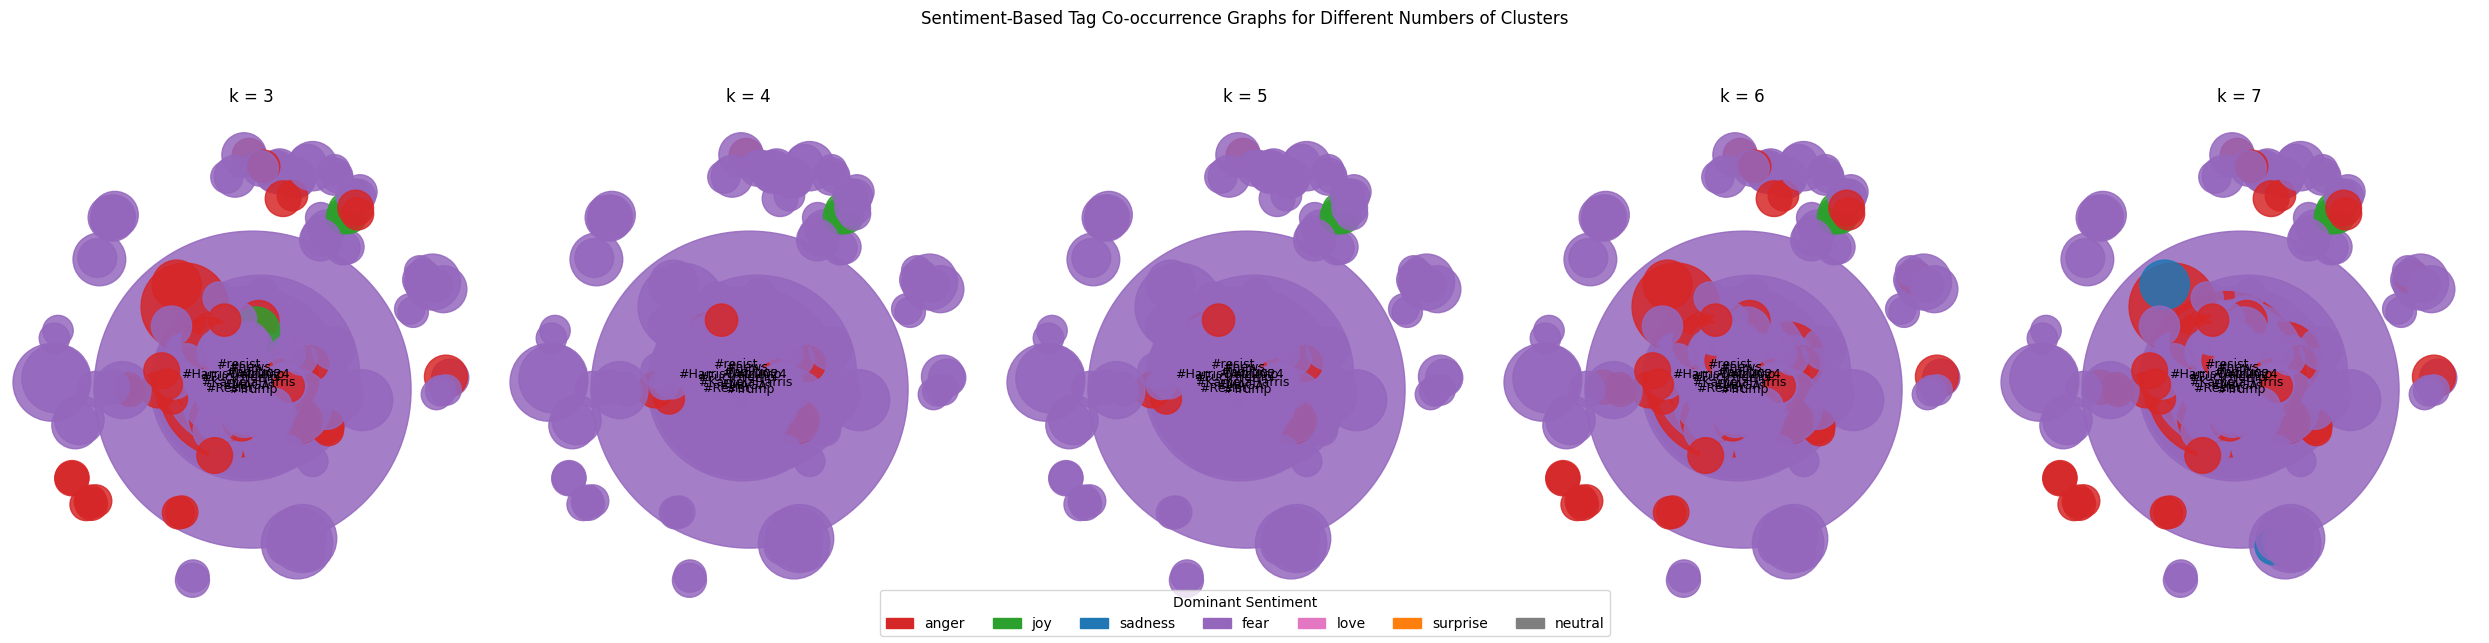

In [25]:
k_values = [3, 4, 5, 6, 7]

sentiment_colors = {
    "anger": "#d62728",
    "joy": "#2ca02c",
    "sadness": "#1f77b4",
    "fear": "#9467bd",
    "love": "#e377c2",
    "surprise": "#ff7f0e",
    "neutral": "#7f7f7f"
}

tag_freq = Counter(tag for tags in df_results["hashtags"] for tag in tags)
top_tags = {t for t, _ in tag_freq.most_common(10)}

pos = nx.spring_layout(G, seed=42, k=0.7)


fig_graphs, axes = plt.subplots(
    1, len(k_values),
    figsize=(5 * len(k_values), 6),
    sharex=True, sharey=True
)

for ax, k in zip(axes, k_values):

    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(sent_dist_norm.values)

    sent_dist_norm_k = sent_dist_norm.copy()
    sent_dist_norm_k["cluster"] = labels

    cluster_profiles = sent_dist_norm_k.groupby("cluster").mean()
    dominant = cluster_profiles.idxmax(axis=1)

    cluster_names = {
        cid: f"{sent}-dominant (C{cid})"
        for cid, sent in dominant.items()
    }

    nx.set_node_attributes(
        G,
        sent_dist_norm_k["cluster"].map(cluster_names).to_dict(),
        "cluster_name"
    )

    node_sizes = [300 + 60 * tag_freq.get(n, 1) for n in G.nodes()]
    node_colors = []

    for n in G.nodes():
        cname = G.nodes[n].get("cluster_name", "")
        sent = cname.split("-")[0] if cname else "neutral"
        node_colors.append(sentiment_colors.get(sent, "#cccccc"))

    nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        node_size=node_sizes,
        alpha=0.85,
        ax=ax
    )

    nx.draw_networkx_edges(
        G, pos,
        alpha=0.25,
        ax=ax
    )

    labels_dict = {n: n if n in top_tags else "" for n in G.nodes()}
    nx.draw_networkx_labels(
        G, pos,
        labels=labels_dict,
        font_size=9,
        ax=ax
    )

    ax.set_title(f"k = {k}")
    ax.axis("off")

legend_handles = [
    mpatches.Patch(color=color, label=sent)
    for sent, color in sentiment_colors.items()
]

fig_graphs.legend(
    handles=legend_handles,
    title="Dominant Sentiment",
    loc="lower center",
    ncol=len(sentiment_colors)
)

fig_graphs.suptitle(
    "Sentiment-Based Tag Co-occurrence Graphs for Different Numbers of Clusters",
    y=1.05
)

plt.tight_layout()
plt.show()


### Cluster-level sentiment profiles (heatmap) and their difference for different values of *k*

We summarize clusters with heatmaps:
- each row is a hashtag cluster,
- each column is an emotion label,
- and the annotated values are the average sentiment distribution inside that cluster.

This is the compact “table view” of what the clustering learned.
We have visualized heatmaps for all the values of k tested. While clusters remain emotionally coherent for all configurations, increasing k reveals heterogeneous sub-structures within fear-dominant discourse. In contrast, anger-, joy-, and sadness-dominant clusters remain highly stable and pure across k. Beyond k=5, additional clusters primarily subdivide existing affective groups without introducing qualitatively new patterns.


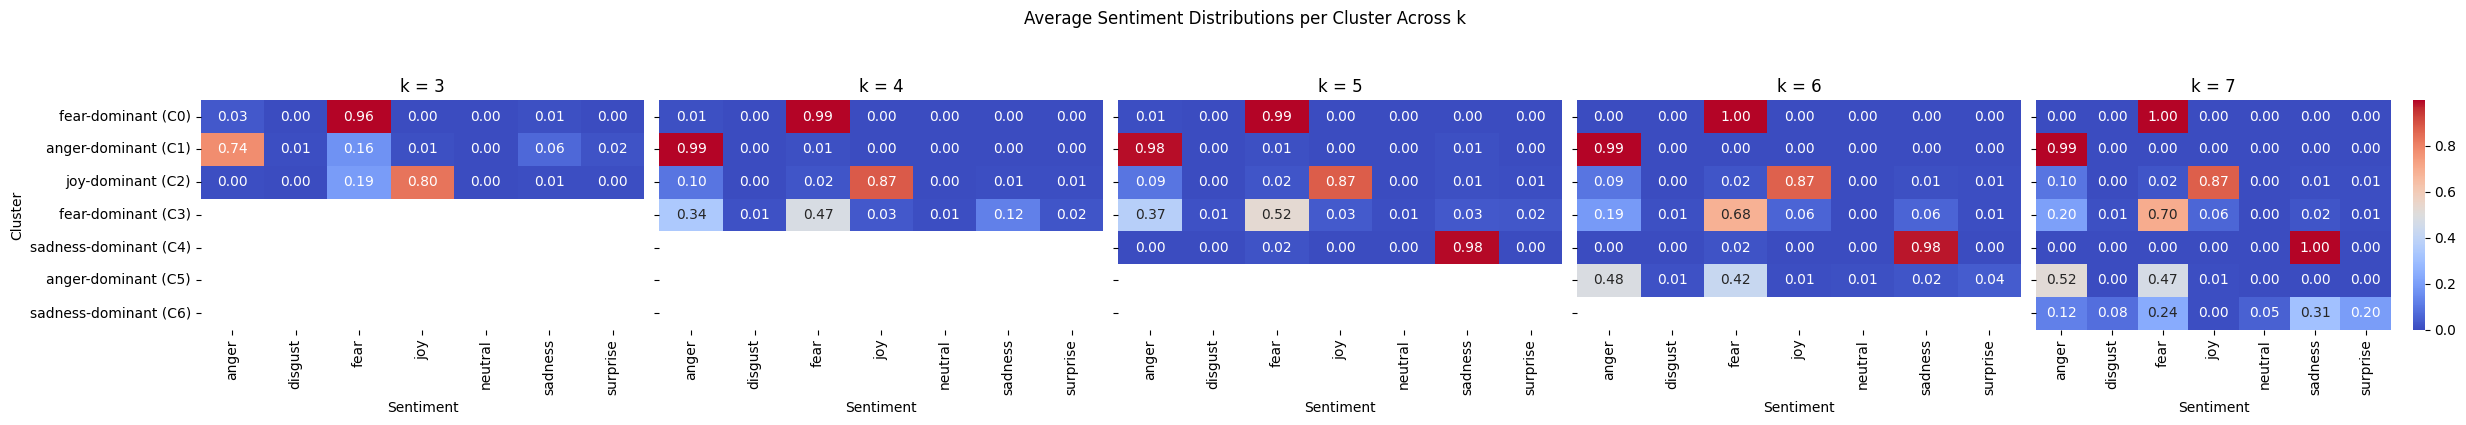

In [19]:

fig_heatmaps, axes = plt.subplots(
    1, len(k_values),
    figsize=(5 * len(k_values), 4),
    sharey=True
)

for ax, k in zip(axes, k_values):

    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(sent_dist_norm.values)

    sent_dist_norm_k = sent_dist_norm.copy()
    sent_dist_norm_k["cluster"] = labels

    cluster_profiles = sent_dist_norm_k.groupby("cluster").mean()
    dominant = cluster_profiles.idxmax(axis=1)

    cluster_names = {
        cid: f"{sent}-dominant (C{cid})"
        for cid, sent in dominant.items()
    }

    cluster_profiles_named = cluster_profiles.copy()
    cluster_profiles_named.index = cluster_profiles_named.index.map(cluster_names)

    sns.heatmap(
        cluster_profiles_named,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        cbar=(ax == axes[-1]),  # colorbar only once
        ax=ax
    )

    ax.set_title(f"k = {k}")
    ax.set_xlabel("Sentiment")
    if ax == axes[0]:
        ax.set_ylabel("Cluster")
    else:
        ax.set_ylabel("")

fig_heatmaps.suptitle(
    "Average Sentiment Distributions per Cluster Across k",
    y=1.05
)

plt.tight_layout()
plt.show()


### Detailed view: focused graph from 5 clusters

To give more context to the figures above, we have also visualized what clustering with *k=5* looks like up close.


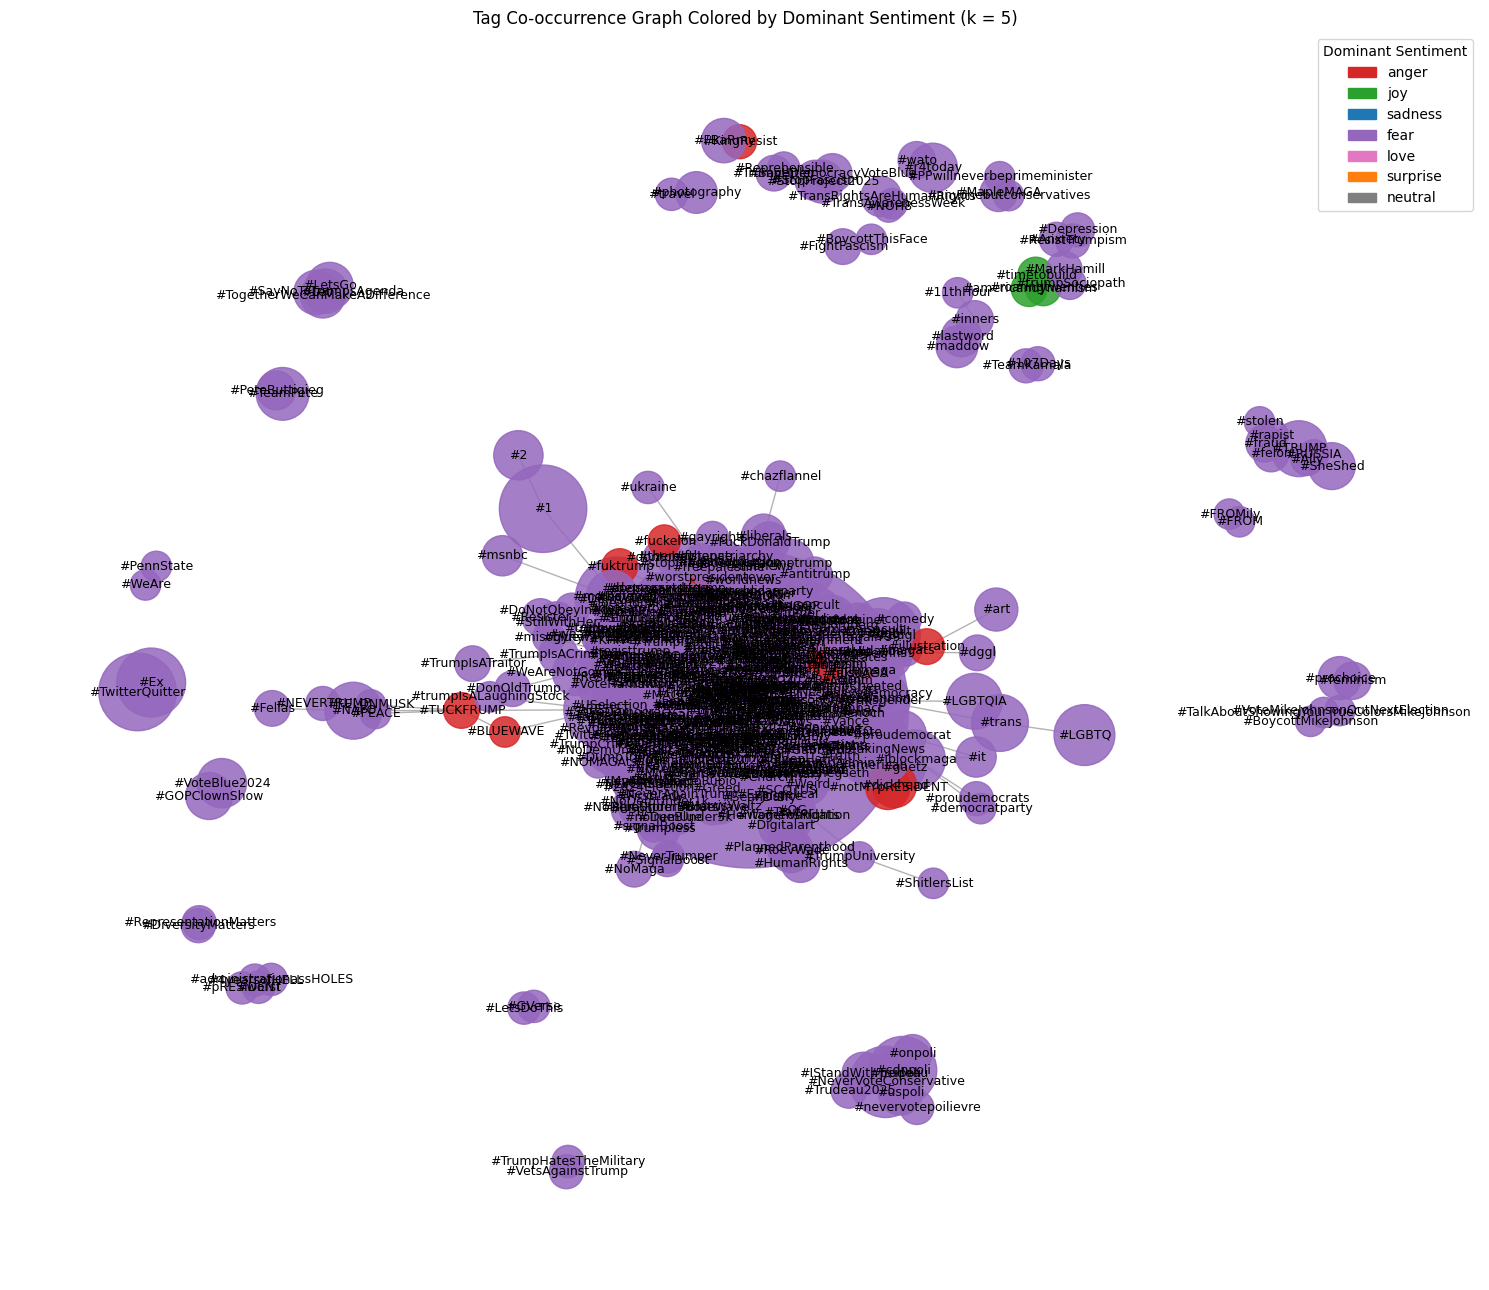

In [22]:

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
sent_dist_norm["cluster"] = kmeans.fit_predict(sent_dist_norm.values)

cluster_profiles = sent_dist_norm.groupby("cluster").mean()

dominant_sentiment = cluster_profiles.idxmax(axis=1)

cluster_names = {
    cid: f"{sent}-dominant (C{cid})"
    for cid, sent in dominant_sentiment.items()
}

sent_dist_norm["cluster_name"] = sent_dist_norm["cluster"].map(cluster_names)

nx.set_node_attributes(
    G,
    sent_dist_norm["cluster_name"].to_dict(),
    "cluster_name"
)

tag_freq = Counter(tag for tags in df_results["hashtags"] for tag in tags)
node_sizes = [300 + 60 * tag_freq.get(n, 1) for n in G.nodes()]

node_colors = []
for n in G.nodes():
    cname = G.nodes[n].get("cluster_name", "")
    sent = cname.split("-")[0] if cname else "neutral"
    node_colors.append(sentiment_colors.get(sent, "#cccccc"))


pos_fixed = nx.spring_layout(G, seed=42, k=0.7)


plt.figure(figsize=(15, 13))

nx.draw_networkx_nodes(
    G, pos_fixed,
    node_color=node_colors,
    node_size=node_sizes,
    alpha=0.85
)

nx.draw_networkx_edges(
    G, pos_fixed,
    alpha=0.3
)

nx.draw_networkx_labels(
    G, pos_fixed,
    font_size=9
)

legend_handles = [
    mpatches.Patch(color=color, label=sent)
    for sent, color in sentiment_colors.items()
]

plt.legend(
    handles=legend_handles,
    title="Dominant Sentiment",
    loc="upper right"
)

plt.title("Tag Co-occurrence Graph Colored by Dominant Sentiment (k = 5)")
plt.axis("off")
plt.tight_layout()
plt.show()


### Focused view: top 10 tags

To keep the graph readable, we take the **10 most frequent hashtags** and plot the induced subgraph.
In the original run noted in the notebook, these top nodes are described as being connected to **fear**.


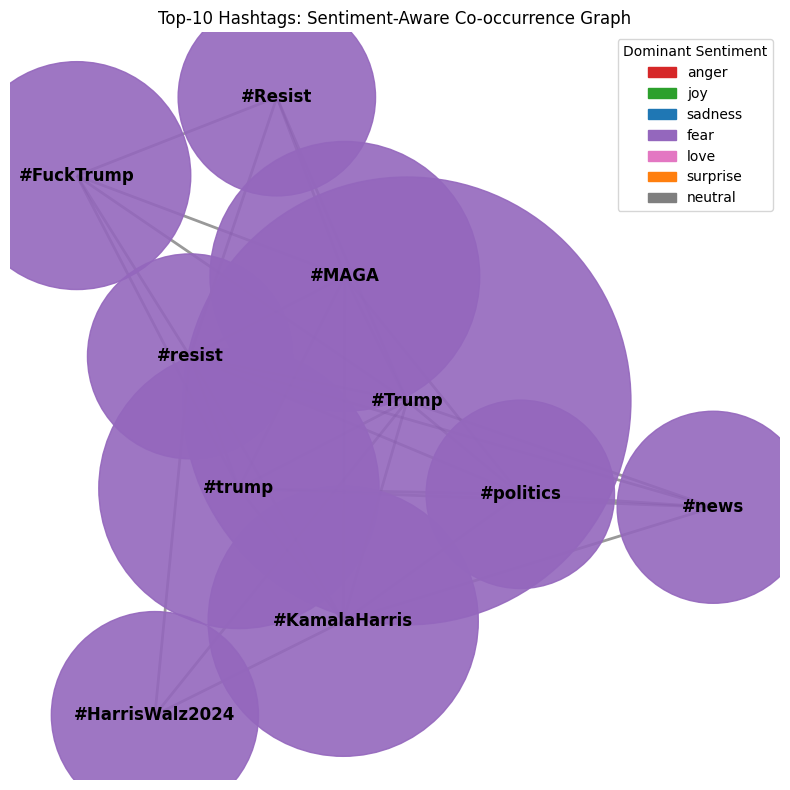

In [23]:


tag_freq = Counter(tag for tags in df_results["hashtags"] for tag in tags)
top_tags = {tag for tag, _ in tag_freq.most_common(10)}

G_top = G.subgraph(top_tags).copy()

node_sizes = [
    400 + 120 * tag_freq.get(n, 1)
    for n in G_top.nodes()
]

node_colors = []
for n in G_top.nodes():
    cname = G_top.nodes[n].get("cluster_name", "")
    sent = cname.split("-")[0] if cname else "neutral"
    node_colors.append(sentiment_colors.get(sent, "#cccccc"))


pos = nx.spring_layout(G_top, seed=42, k=1.2)


plt.figure(figsize=(8, 8))

nx.draw_networkx_nodes(
    G_top, pos,
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.9
)

nx.draw_networkx_edges(
    G_top, pos,
    width=2,
    alpha=0.4
)

nx.draw_networkx_labels(
    G_top, pos,
    font_size=12,
    font_weight="bold"
)

legend_handles = [
    mpatches.Patch(color=color, label=sent)
    for sent, color in sentiment_colors.items()
]

plt.legend(
    handles=legend_handles,
    title="Dominant Sentiment",
    loc="upper right"
)

plt.title("Top-10 Hashtags: Sentiment-Aware Co-occurrence Graph")
plt.axis("off")
plt.tight_layout()
plt.show()


### More detailed analysis on the  sentiment profiles/heatmaps for the chosen *k=5* clusters




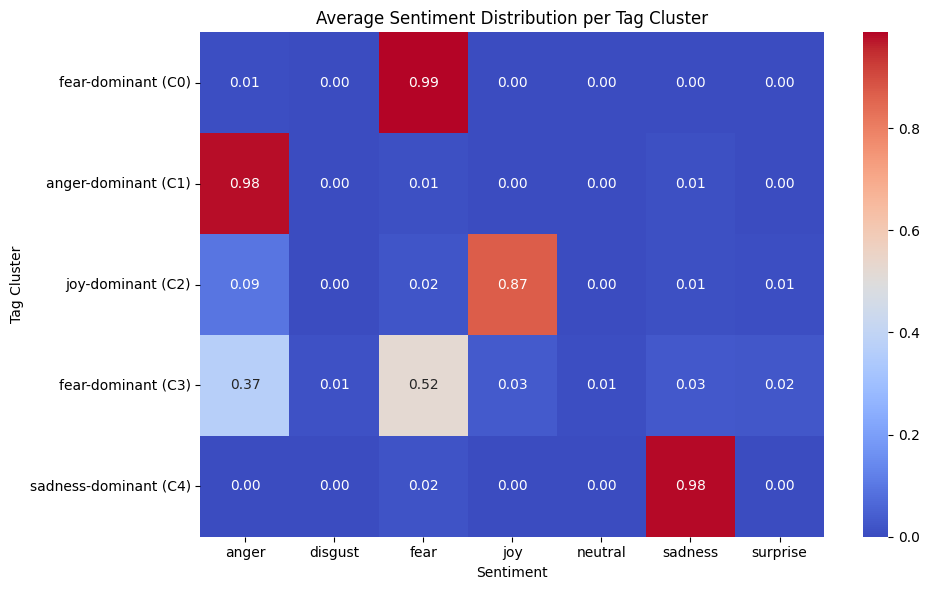

In [ ]:

cluster_profiles_named = cluster_profiles.copy()
cluster_profiles_named.index = cluster_profiles_named.index.map(cluster_names)

plt.figure(figsize=(10, 6))
sns.heatmap(
    cluster_profiles_named,
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)
plt.title("Average Sentiment Distribution per Tag Cluster")
plt.xlabel("Sentiment")
plt.ylabel("Tag Cluster")
plt.tight_layout()
plt.show()

As we can see there are two fear-dominant rows, however they are part of different clusters, since clustering also takes into account the secondary emotions.

In [ ]:
fear_clusters = [
    cid for cid, s in dominant_sentiment.items()
    if s == "fear"
]

cluster_profiles.loc[fear_clusters]
sent_dist_norm_reset = sent_dist_norm.reset_index()

for cid in fear_clusters:
    tags = (
        sent_dist_norm_reset[sent_dist_norm_reset["cluster"] == cid]
        .sort_values(by="fear", ascending=False)
        .head(10)["tag"]
        .tolist()
    )
    print(f"\nFear cluster C{cid} top tags:", tags)



Fear cluster C0 top tags: ['#𝒜𝓉𝓉𝒾𝒸𝓊𝓈', '#zhongli', '#10', '#11thHour', '#14Forever', '#2023Debate', '#2024', '#2024ELECTION', '#2024Elections', '#2024GeneralElection']

Fear cluster C3 top tags: ['#msnbc', '#treason', '#Traitor', '#TrumpGrabinet', '#us', '#republican', '#resistfascism', '#trump', '#MAGA', '#merrickgarland']






*   Cluster **C0** is characterized by an almost pure fear signal, with negligible contributions from other emotions.
*   Cluster **C3** combines fear with a strong anger component, indicating a hostile or adversarial framing.



In [ ]:
summary = []

for cid in fear_clusters:
    row = cluster_profiles.loc[cid].to_dict()
    row["cluster"] = f"C{cid}"
    row["top_tags"] = ", ".join(
        sent_dist_norm_reset[sent_dist_norm_reset["cluster"] == cid]
        .sort_values(by="fear", ascending=False)
        .head(5)["tag"]
    )
    summary.append(row)

pd.DataFrame(summary)


,anger,disgust,fear,joy,neutral,sadness,surprise,cluster,top_tags
0,0.007511,0.000404,0.987265,0.001804,0.000021,0.002499,0.000496,C0,"#𝒜𝓉𝓉𝒾𝒸𝓊𝓈, #zhongli, #10, #11thHour, #14Forever"
1,0.368900,0.013625,0.524356,0.032116,0.006312,0.030470,0.024221,C3,"#msnbc, #treason, #Traitor, #TrumpGrabinet, #us"
